<a href="https://colab.research.google.com/github/silviolima07/Clusters/blob/main/Solar_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identificar grupos de cidades para receber uma industria de bebidas.
# Uma estrategia usada foi usar apenas as colunas mais relevantes dentro do contexto do problema.
# Foram identificados no dataset, grupos de cidades com renda per capita semelhante e grupos de cidades com distancia ate a capital, semelhantes.
# Dessa forma foram identificados grupos de cidades que apresentam a mesma faixa de renda e mesma faixa de distancia ate a capital.
# Outra estrategia adotada foi remover as colunas categoricas e aplicar o algoritmo Kmeans para identificar grupos de cidades no dataset.
# Foram identificados 3 grupos de cidades em cada uma das estrategias.
# O cluster de renda foi caracterizados pelo valor medio. Assim, podemos identificar a renda media das cidades de cada grupo.
# O mesmo procedimento foi feito para o cluster de distancia ate a capital.

# Tarefas:
- Classifique os municípios brasileiros com base nas informações disponíveis (utilize um algoritmo de  cluster, se julgar necessário). Caracterize os grupos de municípios criado da melhor maneira possível. 

- Quais grupos de municípios deveriam ser a porta de entrada para empresa no país? Por quê?

- Elabore um modelo de classificação para o cálculo da probabilidade de um determinado município pertencer a um dos grupos 


In [615]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#
import warnings
warnings.filterwarnings("ignore")

from sklearn import preprocessing, cluster
import yellowbrick
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

from sklearn.preprocessing import MinMaxScaler

from sklearn import preprocessing, metrics

%matplotlib inline


In [616]:
def hist_plot(df,var,bins=20):
  return df.hist(column = var, figsize=(7,6), bins=bins);

In [617]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [618]:
def number_of_cluster(coluna):
  sse={}
  df_cluster = df[[coluna]]
  for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_cluster)
    df_cluster["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
    
  plt.figure(figsize=(10, 5))
  plt.plot(list(sse.keys()), list(sse.values()))
  plt.title("Number of Cluster by Column\n"+coluna)
  plt.xlabel("Number of cluster")
  plt.show()

In [619]:
def create_cluster(df,coluna, nova_coluna):
  #building 3 clusters for Frequency and adding it to dataframe
  kmeans = KMeans(n_clusters=3)
  kmeans.fit(df[[coluna]])
  df[nova_coluna] = kmeans.predict(df[[coluna]])
  df = order_cluster(nova_coluna, coluna,df,False)

In [620]:
def xgb_model (X_treino, y_treino, cv=10):
  cv_scores = cross_val_score(xgb, X_treino, y_treino, cv=cv, scoring='accuracy')
  print("Média dos", cv, "testes:", np.round(cv_scores.mean(),4)) 

In [621]:
df = pd.read_csv('/content/drive/MyDrive/base_municipio.csv', encoding='latin-1')

In [622]:
df

,Código,Município,UF,Área (km²),"Densidade demográfica, 2000",Distância à capital (km),"Esperança de vida ao nascer, 2000","Mortalidade até um ano de idade, 2000","Taxa de fecundidade total, 2000","Percentual de pessoas de 25 anos ou mais analfabetas, 2000",...,"Taxa de alfabetização, 2000","Média de anos de estudo das pessoas de 25 anos ou mais de idade, 2000","População de 25 anos ou mais de idade, 1991","População de 25 anos ou mais de idade, 2000","População de 65 anos ou mais de idade, 1991","População de 65 anos ou mais de idade, 2000","População total, 1991","População total, 2000","População urbana, 2000","População rural, 2000"
0,130230,Jutaí,AM,69857.4,0.3,749.232205,61.25,63.34,5.74,50.62,...,54.90,2.08,4242,6210,171,466,14890,22500,7725,14775
1,130380,São Gabriel da Cachoeira,AM,109669.0,0.3,851.225150,68.60,34.20,3.21,33.99,...,76.85,3.90,8762,11783,938,1096,23140,29947,12373,17574
2,291110,Formosa do Rio Preto,BA,16514.3,1.1,756.981922,64.30,44.73,3.49,40.20,...,67.70,2.90,5315,6935,583,777,15418,18288,9381,8907
3,500560,Miranda,MS,5494.5,4.2,181.846641,65.05,41.64,3.11,23.02,...,83.40,4.15,8317,10601,898,1141,20176,23007,12059,10948
4,431730,Santa Vitória do Palmar,RS,5242.7,6.4,436.821147,68.63,24.70,2.85,10.70,...,91.11,5.70,16093,18638,1938,2605,30056,33304,27952,5352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5502,431848,São José do Hortêncio,RS,64.5,52.4,56.152137,76.82,8.37,2.18,3.15,...,97.31,5.14,1374,2043,195,296,2383,3387,2093,1294
5503,432330,Vila Flores,RS,125.0,24.7,133.275166,75.51,10.45,2.01,6.00,...,94.81,5.31,1553,1901,184,285,2650,3086,1045,2041
5504,431162,Lindolfo Collor,RS,31.8,142.9,48.490606,75.81,9.96,2.26,4.60,...,95.62,4.74,1179,2255,98,173,2543,4414,3418,996
5505,290290,Barra do Choça,BA,781.3,52.2,307.875581,63.50,47.63,3.26,49.27,...,64.33,1.75,9187,17090,991,1693,24844,40818,17721,23097


In [623]:
df.columns

Index(['Código', 'Município', 'UF', 'Área (km²)',
       'Densidade demográfica, 2000', 'Distância à capital (km)',
       'Esperança de vida ao nascer, 2000',
       'Mortalidade até um ano de idade, 2000',
       'Taxa de fecundidade total, 2000',
       'Percentual de pessoas de 25 anos ou mais analfabetas, 2000',
       'Renda per Capita, 2000', 'Índice de Gini, 2000',
       'Intensidade da indigência, 2000', 'Intensidade da pobreza, 2000',
       'Índice de Desenvolvimento Humano Municipal, 2000',
       'Taxa bruta de freqüência à escola, 2000',
       'Taxa de alfabetização, 2000',
       'Média de anos de estudo das pessoas de 25 anos ou mais de idade, 2000',
       'População de 25 anos ou mais de idade, 1991',
       'População de 25 anos ou mais de idade, 2000',
       'População de 65 anos ou mais de idade, 1991',
       'População de 65 anos ou mais de idade, 2000', 'População total, 1991',
       'População total, 2000', 'População urbana, 2000',
       'População rural,

In [624]:
df.isnull().sum()

Código                                                                   0
Município                                                                0
UF                                                                       0
Área (km²)                                                               0
Densidade demográfica, 2000                                              0
Distância à capital (km)                                                 0
Esperança de vida ao nascer, 2000                                        0
Mortalidade até um ano de idade, 2000                                    0
Taxa de fecundidade total, 2000                                          0
Percentual de pessoas de 25 anos ou mais analfabetas, 2000               0
Renda per Capita, 2000                                                   0
Índice de Gini, 2000                                                     0
Intensidade da indigência, 2000                                          0
Intensidade da pobreza, 2

In [625]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5507 entries, 0 to 5506
Data columns (total 26 columns):
 #   Column                                                                 Non-Null Count  Dtype  
---  ------                                                                 --------------  -----  
 0   Código                                                                 5507 non-null   int64  
 1   Município                                                              5507 non-null   object 
 2   UF                                                                     5507 non-null   object 
 3   Área (km²)                                                             5507 non-null   float64
 4   Densidade demográfica, 2000                                            5507 non-null   float64
 5   Distância à capital (km)                                               5507 non-null   float64
 6   Esperança de vida ao nascer, 2000                                      5507 non-null   f

## Manter apenas os dados referentes ao ano 2000

In [626]:
ano_1991 = [
       'População de 25 anos ou mais de idade, 1991',
       'População de 65 anos ou mais de idade, 1991',
       'População total, 1991']

In [627]:
df.drop(columns=ano_1991, inplace=True)

In [628]:
df.drop(columns=['Código'], inplace=True)

In [629]:
df

,Município,UF,Área (km²),"Densidade demográfica, 2000",Distância à capital (km),"Esperança de vida ao nascer, 2000","Mortalidade até um ano de idade, 2000","Taxa de fecundidade total, 2000","Percentual de pessoas de 25 anos ou mais analfabetas, 2000","Renda per Capita, 2000",...,"Intensidade da pobreza, 2000","Índice de Desenvolvimento Humano Municipal, 2000","Taxa bruta de freqüência à escola, 2000","Taxa de alfabetização, 2000","Média de anos de estudo das pessoas de 25 anos ou mais de idade, 2000","População de 25 anos ou mais de idade, 2000","População de 65 anos ou mais de idade, 2000","População total, 2000","População urbana, 2000","População rural, 2000"
0,Jutaí,AM,69857.4,0.3,749.232205,61.25,63.34,5.74,50.62,60.79,...,69.64,0.533,51.33,54.90,2.08,6210,466,22500,7725,14775
1,São Gabriel da Cachoeira,AM,109669.0,0.3,851.225150,68.60,34.20,3.21,33.99,106.61,...,70.92,0.673,68.38,76.85,3.90,11783,1096,29947,12373,17574
2,Formosa do Rio Preto,BA,16514.3,1.1,756.981922,64.30,44.73,3.49,40.20,117.52,...,65.16,0.646,79.18,67.70,2.90,6935,777,18288,9381,8907
3,Miranda,MS,5494.5,4.2,181.846641,65.05,41.64,3.11,23.02,248.19,...,53.55,0.724,76.35,83.40,4.15,10601,1141,23007,12059,10948
4,Santa Vitória do Palmar,RS,5242.7,6.4,436.821147,68.63,24.70,2.85,10.70,406.43,...,38.22,0.799,85.84,91.11,5.70,18638,2605,33304,27952,5352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5502,São José do Hortêncio,RS,64.5,52.4,56.152137,76.82,8.37,2.18,3.15,250.83,...,32.32,0.815,71.58,97.31,5.14,2043,296,3387,2093,1294
5503,Vila Flores,RS,125.0,24.7,133.275166,75.51,10.45,2.01,6.00,246.57,...,31.42,0.818,86.00,94.81,5.31,1901,285,3086,1045,2041
5504,Lindolfo Collor,RS,31.8,142.9,48.490606,75.81,9.96,2.26,4.60,240.11,...,30.94,0.805,72.43,95.62,4.74,2255,173,4414,3418,996
5505,Barra do Choça,BA,781.3,52.2,307.875581,63.50,47.63,3.26,49.27,71.75,...,40.71,0.603,75.63,64.33,1.75,17090,1693,40818,17721,23097


In [630]:
df.Município = df.Município.str.strip()

## Distribuição da renda per capita pelas cidades

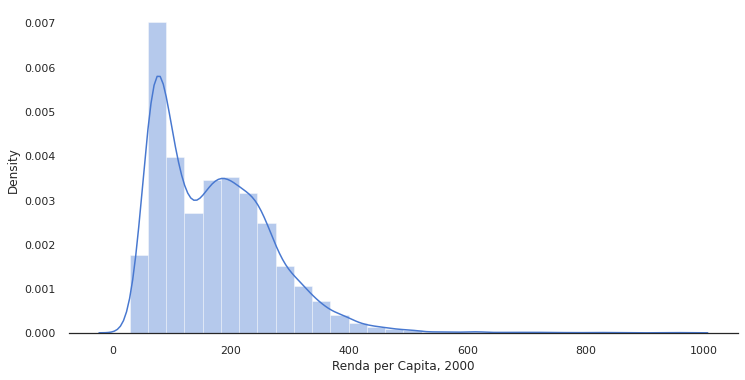

In [631]:
sns.set(palette='muted', color_codes=True, style='white')
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(df['Renda per Capita, 2000'], bins=30)
plt.show();

# Distribuição da distância da cidade até a capital.

---



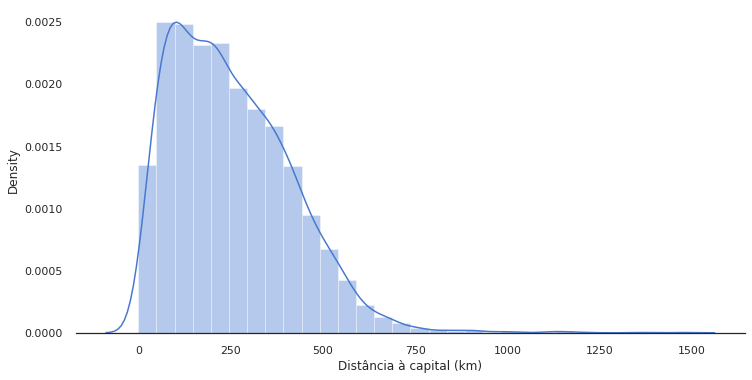

In [632]:
sns.set(palette='muted', color_codes=True, style='white')
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(df['Distância à capital (km)'], bins=30)
plt.show();

## Quantidade de clusters para Renda per Capita

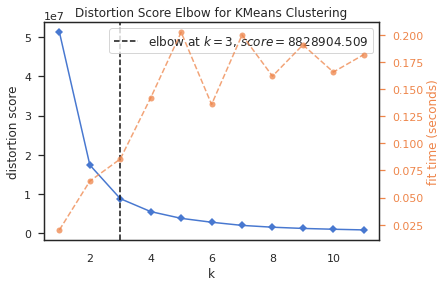

In [633]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))
X = df['Renda per Capita, 2000'].values.reshape(-1,1)

visualizer.fit(X)    # Fit the data to the visualizer
visualizer.poof() ;   # Draw/show/poof the data

In [634]:
create_cluster(df,'Renda per Capita, 2000', 'Cluster_Renda' )

In [635]:
df[['Renda per Capita, 2000', 'Cluster_Renda']]


,"Renda per Capita, 2000",Cluster_Renda
0,60.79,1
1,106.61,1
2,117.52,1
3,248.19,2
4,406.43,0
...,...,...
5502,250.83,2
5503,246.57,2
5504,240.11,2
5505,71.75,1


## Quantidade de clusters para Distancia a capital

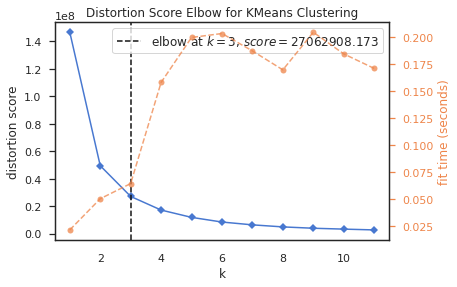

In [636]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))
X = df['Distância à capital (km)'].values.reshape(-1,1)

visualizer.fit(X)    # Fit the data to the visualizer
visualizer.poof();    # Draw/show/poof the data

In [637]:
create_cluster(df,'Distância à capital (km)', 'Cluster_Distancia' )

In [638]:
df[['Distância à capital (km)', 'Cluster_Distancia']]

,Distância à capital (km),Cluster_Distancia
0,749.232205,2
1,851.225150,2
2,756.981922,2
3,181.846641,1
4,436.821147,2
...,...,...
5502,56.152137,1
5503,133.275166,1
5504,48.490606,1
5505,307.875581,0


## Totais de cidades em cada grupo

In [639]:
df.Cluster_Renda.value_counts()

1    2611
2    2215
0     681
Name: Cluster_Renda, dtype: int64

In [640]:
df.Cluster_Distancia.value_counts()

1    2474
0    2101
2     932
Name: Cluster_Distancia, dtype: int64

In [641]:
df_all_cols = df

In [642]:
df_all_cols[['Município', 'Cluster_Renda', 'Cluster_Distancia']]


,Município,Cluster_Renda,Cluster_Distancia
0,Jutaí,1,2
1,São Gabriel da Cachoeira,1,2
2,Formosa do Rio Preto,1,2
3,Miranda,2,1
4,Santa Vitória do Palmar,0,2
...,...,...,...
5502,São José do Hortêncio,2,1
5503,Vila Flores,2,1
5504,Lindolfo Collor,2,1
5505,Barra do Choça,1,0


#Aplicando kmeans a todas variaveis numericas

In [643]:
df = pd.read_csv('/content/drive/MyDrive/base_municipio.csv', encoding='latin-1')

In [644]:
df.drop(columns=['Código'], inplace=True)

In [645]:
df2 = df.copy()

## Manter apenas as variaveis numericas

In [646]:
df2.drop(['Município', 'UF'], axis=1, inplace=True)

In [647]:
df2.head()

,Área (km²),"Densidade demográfica, 2000",Distância à capital (km),"Esperança de vida ao nascer, 2000","Mortalidade até um ano de idade, 2000","Taxa de fecundidade total, 2000","Percentual de pessoas de 25 anos ou mais analfabetas, 2000","Renda per Capita, 2000","Índice de Gini, 2000","Intensidade da indigência, 2000",...,"Taxa de alfabetização, 2000","Média de anos de estudo das pessoas de 25 anos ou mais de idade, 2000","População de 25 anos ou mais de idade, 1991","População de 25 anos ou mais de idade, 2000","População de 65 anos ou mais de idade, 1991","População de 65 anos ou mais de idade, 2000","População total, 1991","População total, 2000","População urbana, 2000","População rural, 2000"
0,69857.4,0.3,749.232205,61.25,63.34,5.74,50.62,60.79,0.82,76.17,...,54.90,2.08,4242,6210,171,466,14890,22500,7725,14775
1,109669.0,0.3,851.225150,68.60,34.20,3.21,33.99,106.61,0.81,88.35,...,76.85,3.90,8762,11783,938,1096,23140,29947,12373,17574
2,16514.3,1.1,756.981922,64.30,44.73,3.49,40.20,117.52,0.80,69.33,...,67.70,2.90,5315,6935,583,777,15418,18288,9381,8907
3,5494.5,4.2,181.846641,65.05,41.64,3.11,23.02,248.19,0.80,56.41,...,83.40,4.15,8317,10601,898,1141,20176,23007,12059,10948
4,5242.7,6.4,436.821147,68.63,24.70,2.85,10.70,406.43,0.80,50.81,...,91.11,5.70,16093,18638,1938,2605,30056,33304,27952,5352


In [648]:
X = df2

In [649]:
X.head()

,Área (km²),"Densidade demográfica, 2000",Distância à capital (km),"Esperança de vida ao nascer, 2000","Mortalidade até um ano de idade, 2000","Taxa de fecundidade total, 2000","Percentual de pessoas de 25 anos ou mais analfabetas, 2000","Renda per Capita, 2000","Índice de Gini, 2000","Intensidade da indigência, 2000",...,"Taxa de alfabetização, 2000","Média de anos de estudo das pessoas de 25 anos ou mais de idade, 2000","População de 25 anos ou mais de idade, 1991","População de 25 anos ou mais de idade, 2000","População de 65 anos ou mais de idade, 1991","População de 65 anos ou mais de idade, 2000","População total, 1991","População total, 2000","População urbana, 2000","População rural, 2000"
0,69857.4,0.3,749.232205,61.25,63.34,5.74,50.62,60.79,0.82,76.17,...,54.90,2.08,4242,6210,171,466,14890,22500,7725,14775
1,109669.0,0.3,851.225150,68.60,34.20,3.21,33.99,106.61,0.81,88.35,...,76.85,3.90,8762,11783,938,1096,23140,29947,12373,17574
2,16514.3,1.1,756.981922,64.30,44.73,3.49,40.20,117.52,0.80,69.33,...,67.70,2.90,5315,6935,583,777,15418,18288,9381,8907
3,5494.5,4.2,181.846641,65.05,41.64,3.11,23.02,248.19,0.80,56.41,...,83.40,4.15,8317,10601,898,1141,20176,23007,12059,10948
4,5242.7,6.4,436.821147,68.63,24.70,2.85,10.70,406.43,0.80,50.81,...,91.11,5.70,16093,18638,1938,2605,30056,33304,27952,5352


In [650]:
cols = X.columns

## Normalizando as escala de valores

In [651]:
ms = MinMaxScaler()

X = ms.fit_transform(X)

In [652]:
X = pd.DataFrame(X, columns=[cols])

In [653]:
X.head()

,Área (km²),"Densidade demográfica, 2000",Distância à capital (km),"Esperança de vida ao nascer, 2000","Mortalidade até um ano de idade, 2000","Taxa de fecundidade total, 2000","Percentual de pessoas de 25 anos ou mais analfabetas, 2000","Renda per Capita, 2000","Índice de Gini, 2000","Intensidade da indigência, 2000",...,"Taxa de alfabetização, 2000","Média de anos de estudo das pessoas de 25 anos ou mais de idade, 2000","População de 25 anos ou mais de idade, 1991","População de 25 anos ou mais de idade, 2000","População de 65 anos ou mais de idade, 1991","População de 65 anos ou mais de idade, 2000","População total, 1991","População total, 2000","População urbana, 2000","População rural, 2000"
0,0.432688,0.000016,0.508190,0.289551,0.555758,0.670947,0.712192,0.034990,1.000000,0.862108,...,0.260418,0.143665,0.000784,0.000994,0.000308,0.000654,0.001479,0.002080,0.000787,0.023790
1,0.679287,0.000016,0.577370,0.597986,0.276345,0.264848,0.468494,0.084457,0.978261,1.000000,...,0.627782,0.349548,0.001669,0.001950,0.001843,0.001594,0.002334,0.002794,0.001261,0.028297
2,0.102274,0.000078,0.513447,0.417541,0.377313,0.309791,0.559496,0.096235,0.956522,0.784671,...,0.474644,0.236425,0.000994,0.001118,0.001132,0.001118,0.001534,0.001677,0.000956,0.014341
3,0.034016,0.000318,0.123343,0.449014,0.347684,0.248796,0.307737,0.237307,0.956522,0.638401,...,0.737406,0.377828,0.001582,0.001747,0.001762,0.001661,0.002027,0.002129,0.001229,0.017628
4,0.032456,0.000489,0.296288,0.599245,0.185253,0.207063,0.127198,0.408142,0.956522,0.575003,...,0.866444,0.553167,0.003105,0.003127,0.003843,0.003843,0.003051,0.003116,0.002848,0.008617


## Utilizando metodos da lib Yellowbrick para identificar o numero de cluster

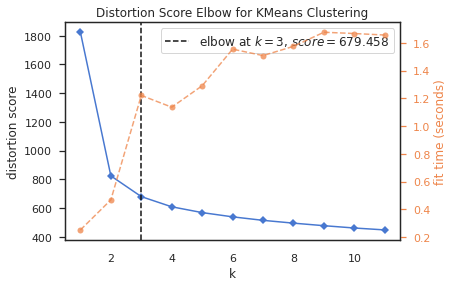

In [654]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))
X = X

visualizer.fit(X)    # Fit the data to the visualizer
visualizer.poof();    # Draw/show/poof the data

## Criar o total de clusters informado no passo anterior

In [655]:
kmeans = KMeans(n_clusters=3, random_state=0) 

kmeans.fit(X)

KMeans(n_clusters=3, random_state=0)

In [656]:
df2['3_clusters'] = kmeans.labels_

In [657]:
df2['3_clusters']

0       0
1       1
2       0
3       1
4       2
       ..
5502    2
5503    2
5504    2
5505    0
5506    2
Name: 3_clusters, Length: 5507, dtype: int32

In [658]:
df2.columns

Index(['Área (km²)', 'Densidade demográfica, 2000', 'Distância à capital (km)',
       'Esperança de vida ao nascer, 2000',
       'Mortalidade até um ano de idade, 2000',
       'Taxa de fecundidade total, 2000',
       'Percentual de pessoas de 25 anos ou mais analfabetas, 2000',
       'Renda per Capita, 2000', 'Índice de Gini, 2000',
       'Intensidade da indigência, 2000', 'Intensidade da pobreza, 2000',
       'Índice de Desenvolvimento Humano Municipal, 2000',
       'Taxa bruta de freqüência à escola, 2000',
       'Taxa de alfabetização, 2000',
       'Média de anos de estudo das pessoas de 25 anos ou mais de idade, 2000',
       'População de 25 anos ou mais de idade, 1991',
       'População de 25 anos ou mais de idade, 2000',
       'População de 65 anos ou mais de idade, 1991',
       'População de 65 anos ou mais de idade, 2000', 'População total, 1991',
       'População total, 2000', 'População urbana, 2000',
       'População rural, 2000', '3_clusters'],
      dtype='

In [659]:
temp2 = df2['3_clusters']

In [660]:
df3 = pd.concat([df_all_cols,temp2], axis=1)
df3

,Município,UF,Área (km²),"Densidade demográfica, 2000",Distância à capital (km),"Esperança de vida ao nascer, 2000","Mortalidade até um ano de idade, 2000","Taxa de fecundidade total, 2000","Percentual de pessoas de 25 anos ou mais analfabetas, 2000","Renda per Capita, 2000",...,"Taxa de alfabetização, 2000","Média de anos de estudo das pessoas de 25 anos ou mais de idade, 2000","População de 25 anos ou mais de idade, 2000","População de 65 anos ou mais de idade, 2000","População total, 2000","População urbana, 2000","População rural, 2000",Cluster_Renda,Cluster_Distancia,3_clusters
0,Jutaí,AM,69857.4,0.3,749.232205,61.25,63.34,5.74,50.62,60.79,...,54.90,2.08,6210,466,22500,7725,14775,1,2,0
1,São Gabriel da Cachoeira,AM,109669.0,0.3,851.225150,68.60,34.20,3.21,33.99,106.61,...,76.85,3.90,11783,1096,29947,12373,17574,1,2,1
2,Formosa do Rio Preto,BA,16514.3,1.1,756.981922,64.30,44.73,3.49,40.20,117.52,...,67.70,2.90,6935,777,18288,9381,8907,1,2,0
3,Miranda,MS,5494.5,4.2,181.846641,65.05,41.64,3.11,23.02,248.19,...,83.40,4.15,10601,1141,23007,12059,10948,2,1,1
4,Santa Vitória do Palmar,RS,5242.7,6.4,436.821147,68.63,24.70,2.85,10.70,406.43,...,91.11,5.70,18638,2605,33304,27952,5352,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5502,São José do Hortêncio,RS,64.5,52.4,56.152137,76.82,8.37,2.18,3.15,250.83,...,97.31,5.14,2043,296,3387,2093,1294,2,1,2
5503,Vila Flores,RS,125.0,24.7,133.275166,75.51,10.45,2.01,6.00,246.57,...,94.81,5.31,1901,285,3086,1045,2041,2,1,2
5504,Lindolfo Collor,RS,31.8,142.9,48.490606,75.81,9.96,2.26,4.60,240.11,...,95.62,4.74,2255,173,4414,3418,996,2,1,2
5505,Barra do Choça,BA,781.3,52.2,307.875581,63.50,47.63,3.26,49.27,71.75,...,64.33,1.75,17090,1693,40818,17721,23097,1,0,0


In [661]:
df3['3_clusters'].value_counts()

2    2348
0    1666
1    1493
Name: 3_clusters, dtype: int64

In [662]:
df4 = df3[['Município', 'UF', 'Renda per Capita, 2000', 'Distância à capital (km)', 'Cluster_Renda', 'Cluster_Distancia', '3_clusters']]

In [663]:

df4

,Município,UF,"Renda per Capita, 2000",Distância à capital (km),Cluster_Renda,Cluster_Distancia,3_clusters
0,Jutaí,AM,60.79,749.232205,1,2,0
1,São Gabriel da Cachoeira,AM,106.61,851.225150,1,2,1
2,Formosa do Rio Preto,BA,117.52,756.981922,1,2,0
3,Miranda,MS,248.19,181.846641,2,1,1
4,Santa Vitória do Palmar,RS,406.43,436.821147,0,2,2
...,...,...,...,...,...,...,...
5502,São José do Hortêncio,RS,250.83,56.152137,2,1,2
5503,Vila Flores,RS,246.57,133.275166,2,1,2
5504,Lindolfo Collor,RS,240.11,48.490606,2,1,2
5505,Barra do Choça,BA,71.75,307.875581,1,0,0


# Classifique os municípios brasileiros com base nas informações disponíveis (utilize um algoritmo de cluster, se julgar necessário). 
# Caracterize os grupos de municípios criado da melhor maneira possível.

## ***Foram usados os cluster criados a partir da Renda per capita e da Distancia ate a capital.***

## ***Renda media das cidades no grupo***



In [664]:
renda_g2 = df4.loc[df4['Cluster_Renda']==2]['Renda per Capita, 2000']
renda_g1 = df4.loc[df4['Cluster_Renda']==1]['Renda per Capita, 2000']
renda_g0 = df4.loc[df4['Cluster_Renda']==0]['Renda per Capita, 2000']
#
print('Renda media grupo 0: R$',round(renda_g0.mean(),2))
renda_g00 = 'Renda media de R$'+ str(round(renda_g0.mean(),2))
print('Renda media grupo 1: R$',round(renda_g1.mean(),2))
renda_g11 = 'Renda media de R$'+ str(round(renda_g1.mean(),2))
print('Renda media grupo 2: R$',round(renda_g2.mean(),2))
renda_g22 = 'Renda media de R$'+ str(round(renda_g2.mean(),2))
#
# Labels

renda = np.where(df4['Cluster_Renda'] == 0, renda_g00,
          np.where(df4['Cluster_Renda'] == 1, renda_g11,
                     np.where(df4["Cluster_Renda"] == 2, renda_g22, renda_g00)))

Renda media grupo 0: R$ 349.88
Renda media grupo 1: R$ 90.16
Renda media grupo 2: R$ 210.83


In [665]:
temp2 = renda_g2.mean()
temp1 = renda_g1.mean()
temp0 = renda_g0.mean()

In [666]:
if (temp2 > temp1) & (temp2 > temp0):
  max_renda_media = 2
elif (temp1 > temp2) & (temp1 > temp0):
  max_renda_media = 1
elif (temp0 > temp1) & (temp0 > temp2):
  max_renda_media = 0    

In [667]:
max_renda_media

0

In [668]:
df4['Label_Renda'] = renda

In [669]:
df4[['Cluster_Renda', 'Label_Renda']]

,Cluster_Renda,Label_Renda
0,1,Renda media de R$90.16
1,1,Renda media de R$90.16
2,1,Renda media de R$90.16
3,2,Renda media de R$210.83
4,0,Renda media de R$349.88
...,...,...
5502,2,Renda media de R$210.83
5503,2,Renda media de R$210.83
5504,2,Renda media de R$210.83
5505,1,Renda media de R$90.16


## ***Distancia media ate a capital***

In [670]:
distancia_g2 = df4.loc[df4['Cluster_Distancia']==2]['Distância à capital (km)']
distancia_g1 = df4.loc[df4['Cluster_Distancia']==1]['Distância à capital (km)']
distancia_g0 = df4.loc[df4['Cluster_Distancia']==0]['Distância à capital (km)']
#
print('Distância media grupo 0: km',round(distancia_g0.mean(),2))
distancia_g00 = 'Distancia media de '+ str(round(distancia_g0.mean(),2))+' km'
print('Distancia media grupo 1: km',round(distancia_g1.mean(),2))
distancia_g11 = 'Distancia media de '+ str(round(distancia_g1.mean(),2))+' km'
print('Distancia media grupo 2: km',round(distancia_g2.mean(),2))
distancia_g22 = 'Distancia media de '+ str(round(distancia_g2.mean(),2))+' km'
#
# Labels

distancia = np.where(df4['Cluster_Distancia'] == 0, distancia_g00,
          np.where(df4['Cluster_Distancia'] == 1, distancia_g11,
                     np.where(df4["Cluster_Distancia"] == 2, distancia_g22, distancia_g00)))

Distância media grupo 0: km 300.78
Distancia media grupo 1: km 112.61
Distancia media grupo 2: km 519.21


In [671]:
temp2 = distancia_g2.mean()
temp1 = distancia_g1.mean()
temp0 = distancia_g0.mean()

In [672]:
if (temp2 < temp1) & (temp2 < temp0):
  min_distancia_media = 2
elif (temp1 < temp2) & (temp1 < temp0):
  min_distancia_media = 1
elif (temp0 < temp1) & (temp0 < temp2):
  min_distancia_media = 0    

In [673]:
min_distancia_media

1

In [674]:
df4['Label_Distancia'] = distancia

In [675]:
df4[['Cluster_Distancia', 'Label_Distancia']]

,Cluster_Distancia,Label_Distancia
0,2,Distancia media de 519.21 km
1,2,Distancia media de 519.21 km
2,2,Distancia media de 519.21 km
3,1,Distancia media de 112.61 km
4,2,Distancia media de 519.21 km
...,...,...
5502,1,Distancia media de 112.61 km
5503,1,Distancia media de 112.61 km
5504,1,Distancia media de 112.61 km
5505,0,Distancia media de 300.78 km


In [676]:
df4.columns

Index(['Município', 'UF', 'Renda per Capita, 2000', 'Distância à capital (km)',
       'Cluster_Renda', 'Cluster_Distancia', '3_clusters', 'Label_Renda',
       'Label_Distancia'],
      dtype='object')

## Cidades caracterizadas pela renda media e distancia ate a capital

In [677]:
df4[['Município', 'UF',
       'Cluster_Renda', 'Label_Renda','Cluster_Distancia', 
       'Label_Distancia', '3_clusters']]

,Município,UF,Cluster_Renda,Label_Renda,Cluster_Distancia,Label_Distancia,3_clusters
0,Jutaí,AM,1,Renda media de R$90.16,2,Distancia media de 519.21 km,0
1,São Gabriel da Cachoeira,AM,1,Renda media de R$90.16,2,Distancia media de 519.21 km,1
2,Formosa do Rio Preto,BA,1,Renda media de R$90.16,2,Distancia media de 519.21 km,0
3,Miranda,MS,2,Renda media de R$210.83,1,Distancia media de 112.61 km,1
4,Santa Vitória do Palmar,RS,0,Renda media de R$349.88,2,Distancia media de 519.21 km,2
...,...,...,...,...,...,...,...
5502,São José do Hortêncio,RS,2,Renda media de R$210.83,1,Distancia media de 112.61 km,2
5503,Vila Flores,RS,2,Renda media de R$210.83,1,Distancia media de 112.61 km,2
5504,Lindolfo Collor,RS,2,Renda media de R$210.83,1,Distancia media de 112.61 km,2
5505,Barra do Choça,BA,1,Renda media de R$90.16,0,Distancia media de 300.78 km,0


### Quais grupos de municípios deveriam ser a porta de entrada para empresa no país? 
### Por quê?

# Estrategia:
#Identificar as cidades com maior renda media e menor distancia ate a capital

In [678]:
df4

,Município,UF,"Renda per Capita, 2000",Distância à capital (km),Cluster_Renda,Cluster_Distancia,3_clusters,Label_Renda,Label_Distancia
0,Jutaí,AM,60.79,749.232205,1,2,0,Renda media de R$90.16,Distancia media de 519.21 km
1,São Gabriel da Cachoeira,AM,106.61,851.225150,1,2,1,Renda media de R$90.16,Distancia media de 519.21 km
2,Formosa do Rio Preto,BA,117.52,756.981922,1,2,0,Renda media de R$90.16,Distancia media de 519.21 km
3,Miranda,MS,248.19,181.846641,2,1,1,Renda media de R$210.83,Distancia media de 112.61 km
4,Santa Vitória do Palmar,RS,406.43,436.821147,0,2,2,Renda media de R$349.88,Distancia media de 519.21 km
...,...,...,...,...,...,...,...,...,...
5502,São José do Hortêncio,RS,250.83,56.152137,2,1,2,Renda media de R$210.83,Distancia media de 112.61 km
5503,Vila Flores,RS,246.57,133.275166,2,1,2,Renda media de R$210.83,Distancia media de 112.61 km
5504,Lindolfo Collor,RS,240.11,48.490606,2,1,2,Renda media de R$210.83,Distancia media de 112.61 km
5505,Barra do Choça,BA,71.75,307.875581,1,0,0,Renda media de R$90.16,Distancia media de 300.78 km


In [679]:
df4.loc[(df4['Cluster_Renda']== max_renda_media) & (df4['Cluster_Distancia']== min_distancia_media)][['Município', 'UF',
       'Cluster_Renda', 'Label_Renda','Cluster_Distancia', 
       'Label_Distancia', '3_clusters']]

,Município,UF,Cluster_Renda,Label_Renda,Cluster_Distancia,Label_Distancia,3_clusters
40,Santana de Parnaíba,SP,0,Renda media de R$349.88,1,Distancia media de 112.61 km,2
48,Arapoti,PR,0,Renda media de R$349.88,1,Distancia media de 112.61 km,2
70,Paraíso do Tocantins,TO,0,Renda media de R$349.88,1,Distancia media de 112.61 km,2
109,Barueri,SP,0,Renda media de R$349.88,1,Distancia media de 112.61 km,2
127,Lauro de Freitas,BA,0,Renda media de R$349.88,1,Distancia media de 112.61 km,2
...,...,...,...,...,...,...,...
5490,Tupandi,RS,0,Renda media de R$349.88,1,Distancia media de 112.61 km,2
5493,Rodeio,SC,0,Renda media de R$349.88,1,Distancia media de 112.61 km,2
5495,Vale Real,RS,0,Renda media de R$349.88,1,Distancia media de 112.61 km,2
5498,Dois Irmãos,RS,0,Renda media de R$349.88,1,Distancia media de 112.61 km,2


# A analise feita acima, selecionou as cidades com maior renda media e menor distancia media ate a capital. Baseando-se apenas em renda e distancia, essas cidades seriam as apontadas como porta de entrada.
# Maior poder aquisitivo impacta no consumo e por consequencia na produção.
# Menor distancia com a capital, pode significar menor custo para distribuição em grandes centros.

# 

### Elabore um modelo de classificação para o cálculo da probabilidade de um determinado município pertencer a um dos grupos

In [680]:
df2

,Área (km²),"Densidade demográfica, 2000",Distância à capital (km),"Esperança de vida ao nascer, 2000","Mortalidade até um ano de idade, 2000","Taxa de fecundidade total, 2000","Percentual de pessoas de 25 anos ou mais analfabetas, 2000","Renda per Capita, 2000","Índice de Gini, 2000","Intensidade da indigência, 2000",...,"Média de anos de estudo das pessoas de 25 anos ou mais de idade, 2000","População de 25 anos ou mais de idade, 1991","População de 25 anos ou mais de idade, 2000","População de 65 anos ou mais de idade, 1991","População de 65 anos ou mais de idade, 2000","População total, 1991","População total, 2000","População urbana, 2000","População rural, 2000",3_clusters
0,69857.4,0.3,749.232205,61.25,63.34,5.74,50.62,60.79,0.82,76.17,...,2.08,4242,6210,171,466,14890,22500,7725,14775,0
1,109669.0,0.3,851.225150,68.60,34.20,3.21,33.99,106.61,0.81,88.35,...,3.90,8762,11783,938,1096,23140,29947,12373,17574,1
2,16514.3,1.1,756.981922,64.30,44.73,3.49,40.20,117.52,0.80,69.33,...,2.90,5315,6935,583,777,15418,18288,9381,8907,0
3,5494.5,4.2,181.846641,65.05,41.64,3.11,23.02,248.19,0.80,56.41,...,4.15,8317,10601,898,1141,20176,23007,12059,10948,1
4,5242.7,6.4,436.821147,68.63,24.70,2.85,10.70,406.43,0.80,50.81,...,5.70,16093,18638,1938,2605,30056,33304,27952,5352,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5502,64.5,52.4,56.152137,76.82,8.37,2.18,3.15,250.83,0.38,36.26,...,5.14,1374,2043,195,296,2383,3387,2093,1294,2
5503,125.0,24.7,133.275166,75.51,10.45,2.01,6.00,246.57,0.38,20.00,...,5.31,1553,1901,184,285,2650,3086,1045,2041,2
5504,31.8,142.9,48.490606,75.81,9.96,2.26,4.60,240.11,0.37,45.08,...,4.74,1179,2255,98,173,2543,4414,3418,996,2
5505,781.3,52.2,307.875581,63.50,47.63,3.26,49.27,71.75,0.36,36.42,...,1.75,9187,17090,991,1693,24844,40818,17721,23097,0


In [681]:
df2['3_clusters'].value_counts()

2    2348
0    1666
1    1493
Name: 3_clusters, dtype: int64

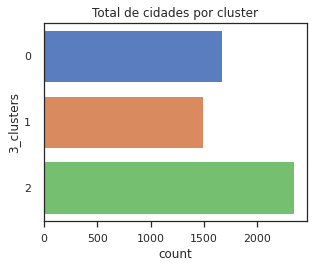

In [682]:
plt.figure(figsize=(16,8))

plt.subplot(233)
sns.countplot(y='3_clusters',data=df2)
plt.gca().xaxis.tick_bottom()
plt.title('Total de cidades por cluster');

In [683]:
# Dividir o dataset em X e y.
# X variáveis preditoras
# y variável target

X = df2.drop('3_clusters', axis=1)
y = df2['3_clusters']

In [684]:
# Normalizar dados

ms = MinMaxScaler()

X = ms.fit_transform(X)

# Modelo

In [685]:
# Divisão dos dados em treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.25, random_state = 0)

## Construção do modelo e avaliação
## XGBClassifier
- accuracia
- probabilidade de cada cluster



In [686]:
# 
xgb = XGBClassifier(learning_rate =0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=2,
                    gamma=0,
                    subsample=0.5,
                    colsample_bytree=0.6,
                    scale_pos_weight=1)
model = xgb.fit(X_treino, y_treino)
fits = xgb.predict(X_treino)
pred = xgb.predict(X_teste)
acc_xgbfits = (fits == y_treino).sum().astype(float) / len(fits)*100
acc_xgbcek = (pred == y_teste).sum().astype(float) / len(pred)*100
print("XGBoost's  acuracia com dados de treino : %3.2f" % (acc_xgbfits))
print("XGBoost's  acuracia com dados de teste : %3.2f" % (acc_xgbcek))
preds = xgb.predict(X_teste)

XGBoost's  acuracia com dados de treino : 100.00
XGBoost's  acuracia com dados de teste : 97.82


In [687]:
#xgb_model(X_treino, y_treino)

In [688]:
cross_val_score(xgb, X_treino, y_treino, cv=10, scoring='accuracy')

array([0.98547215, 0.97094431, 0.99031477, 0.98305085, 0.98062954,
       0.96368039, 0.98062954, 0.99273608, 0.97578692, 0.97578692])

# Calculo da probabilidade de um determinado município pertencer a um dos grupos é a media dos 10 valores retornados no cross_val_score


In [689]:
probabilidade = np.mean([0.98062954, 0.97094431, 0.99031477, 0.98305085, 0.98789346,
       0.96368039, 0.98789346, 0.99273608, 0.97336562, 0.97578692])
#
print("Probabilidade:", str(round(probabilidade,4)*100)+' %')

Probabilidade: 98.06 %
